In [1]:
import os
import sys

sys.path.append("./")  # Adds higher directory to python modules path.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from data_pipeline import *
import numpy as np
import pandas as pd
from core.ODEDataset import  ODEDataset
from utils import cleaning

In [2]:
print("Available devices:", tf.config.list_physical_devices())
logical_devices = tf.config.list_logical_devices()
print("Active logical devices:", logical_devices)

print("Version : ", tf.__version__)

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Active logical devices: [LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
Version :  2.11.0


Let's load the dataset and  select the columns we want to use as features and labels.

## Constants & Parameters

In [3]:
BATCH_SIZE = 4096
Features = [
    #    'Education_level_HHH',
    'Education_level_HHH_Doctoral or equivalent level',
    'Education_level_HHH_Lower secondary education',
    "Education_level_HHH_Master's or equivalent level",
    'Education_level_HHH_No schooling',
    'Education_level_HHH_Not elsewhere classified',
    'Education_level_HHH_Other',
    'Education_level_HHH_Post-secondary non-tertiary education',
    'Education_level_HHH_Primary education',
    'Education_level_HHH_Secondary education',
    'Education_level_HHH_Short-cycle tertiary education',
    'Education_level_HHH_Upper secondary education',
    # 'Socio_status_HHH',
    'Socio_status_HHH_Employee', 'Socio_status_HHH_Employee farm',
    'Socio_status_HHH_Employee non-farm',
    # 'Socio_status_HHH_Employer',
    'Socio_status_HHH_Other', 'Socio_status_HHH_Own-account worker farm',
    'Socio_status_HHH_Own-account worker non-farm',
    'Socio_status_HHH_Unemployed',
    'Socio_status_HHH_Worker not classifiable by status',
    # 'Tariff_payment_frequency',
    'Tariff_payment_frequency_Every 3 months',
    'Tariff_payment_frequency_Every 6 months',
    'Tariff_payment_frequency_Monthly', 'Tariff_payment_frequency_No bill',
    'Tariff_payment_frequency_Other', 'Tariff_payment_frequency_Weekly',

    'HH_with_home_business_Yes',
    'HH_with_home_business_No',
    'HH_with_home_business_missing',

    'Ownership_motorized_vehicle_Yes',
    'Ownership_large_livestock_No',
    'Ownership_motorized_vehicle_missing',

    'Ownership_small_livestock_Yes',
    'Ownership_small_livestock_No',
    'Ownership_small_livestock_missing',

    'Ownership_large_livestock_Yes',
    'Ownership_large_livestock_No',
    'Ownership_large_livestock_missing',

    'Clean_fuel_Yes',
    'Clean_fuel_No',
    'Clean_fuel_missing',

    'Years_of_HHH_in_community',
    'Years_of_HHH_in_community_missing',

    'Dwelling_quality_index',
    'Dwelling_quality_index_missing',

    'Hours_available_electricity',
    'Hours_available_electricity_missing',

    'Measurement_age',
    'Measurement_age_missing',

    'Monthly_expenditure',
    'Monthly_expenditure_missing',

    'Number_of_rooms',
    'Number_of_rooms_missing',
    'Climate_zone_lev_1',
    'Climate_zone_lev_1_missing',

    'Climate_zone_lev_2',
    'Climate_zone_lev_2_missing',

    'Age_HHH',
    'Age_HHH_missing',

    'Number_adults',
    'Number_adults_missing'
]

FEATURE_NUM = len(Features)



In [4]:
# OUTPUT =  "Presence_refrigerator/freezer" # {1.0: 0.13849033063006863, 0.0: 0.8615096693699313}
OUTPUT =  "Presence_iron" # {0.0: 0.7690382552735073, 1.0: 0.23096174472649267}
# OUTPUT =  "Presence_fan" # {1.0: 0.25035427491733586, 0.0: 0.7496457250826641}
# OUTPUT =  "Presence_DVD_player" #  {0.0: 0.8856872933396316, 1.0: 0.11431270666036844}
# OUTPUT =  "Presence_radio/stereo" # {1.0: 0.23284005037783376, 0.0: 0.7671599496221663}
# OUTPUT =  "Presence_phone_charger" # {0.0: 0.7842976561219472, 1.0: 0.2157023438780528}
# OUTPUT =  "Presence_TV" # {0.0: 0.8220796266588887, 1.0: 0.17792037334111127}

## Dataset and Feature Selection

In [5]:
path ="./playground/data/combined_dataset_cleaned.csv"
dataset = ODEDataset("combined_dataset_cleaned")
dataset.from_csv(path)
dataset = dataset.apply(cleaning.remove_row(OUTPUT, -1))
dataset = add_one_hot_encoding(dataset)
df = dataset.to_dataframe()

In [6]:
features =df[Features]
target = df[OUTPUT]

In [7]:
features.head()

,Education_level_HHH_Doctoral or equivalent level,Education_level_HHH_Lower secondary education,Education_level_HHH_Master's or equivalent level,Education_level_HHH_No schooling,Education_level_HHH_Not elsewhere classified,Education_level_HHH_Other,Education_level_HHH_Post-secondary non-tertiary education,Education_level_HHH_Primary education,Education_level_HHH_Secondary education,Education_level_HHH_Short-cycle tertiary education,...,Number_of_rooms,Number_of_rooms_missing,Climate_zone_lev_1,Climate_zone_lev_1_missing,Climate_zone_lev_2,Climate_zone_lev_2_missing,Age_HHH,Age_HHH_missing,Number_adults,Number_adults_missing
0,False,False,False,False,False,False,False,True,False,False,...,3,0,3.0,0,-1.0,1,-1,1,34,0
1,False,False,False,False,False,False,False,True,False,False,...,3,0,3.0,0,-1.0,1,-1,1,34,0
10,False,False,False,False,False,False,False,True,False,False,...,3,0,3.0,0,3.0,0,-1,1,44,0
11,False,False,False,False,False,False,False,True,False,False,...,3,0,3.0,0,3.0,0,-1,1,44,0
12,False,False,False,False,False,False,False,True,False,False,...,3,0,3.0,0,3.0,0,-1,1,44,0


In [8]:
x_train_val, x_test, y_train_val, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2, random_state=42)

### Imbalanced Dataset Handling
We use Imbalanced learning library 
https://imbalanced-learn.org/stable/index.html

In [9]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# sampler = RandomUnderSampler()
sampler = SMOTE(random_state=412)
x_train, y_train = sampler.fit_resample(x_train, y_train )
print(x_train.shape, y_train.shape)

(8604, 60) (8604,)


<Axes: title={'center': 'Training target Distribution'}, ylabel='count'>

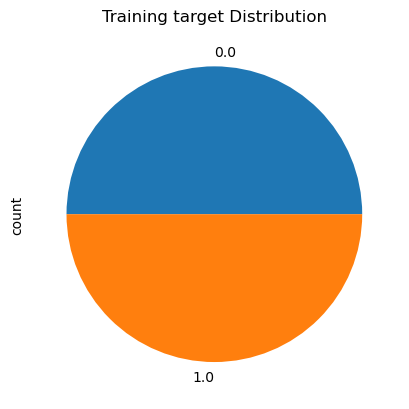

In [10]:
y_train.value_counts().plot(kind='pie', title='Training target Distribution')



<Axes: title={'center': 'Validation target Distribution'}, ylabel='count'>

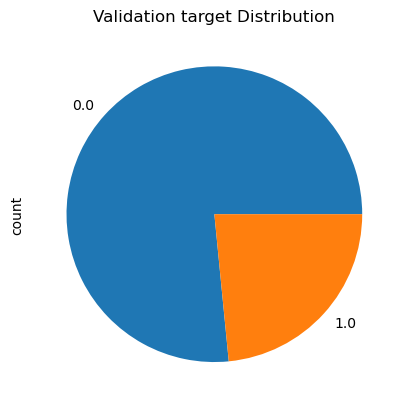

In [11]:
y_val.value_counts().plot(kind='pie', title='Validation target Distribution')

<Axes: title={'center': 'Testing target Distribution'}, ylabel='count'>

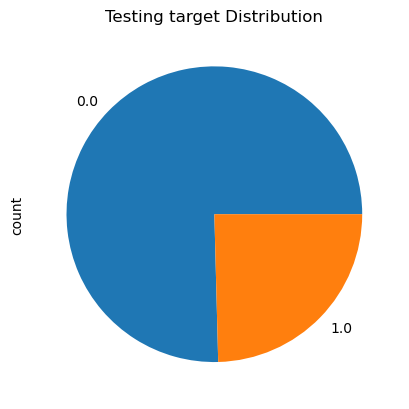

In [12]:
y_test.value_counts().plot(kind='pie', title='Testing target Distribution')

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)

x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

x_train = np.clip(x_train, -5, 5)
x_val = np.clip(x_val, -5, 5)
x_test = np.clip(x_test, -5, 5)


In [14]:
# import seaborn as sns
# pos_df = pd.DataFrame(x_train[ y_train==1], columns=Features)
# neg_df = pd.DataFrame(x_train[y_train==0], columns=Features)

# sns.jointplot(x=pos_df['Dwelling_quality_index'], y=pos_df['Age_HHH'],
#               kind='hex', xlim=(-5,5), ylim=(-5,5))
# plt.suptitle("Positive distribution")

# sns.jointplot(x=neg_df['Dwelling_quality_index'], y=neg_df['Age_HHH'],
#               kind='hex', xlim=(-5,5), ylim=(-5,5))
# _ = plt.suptitle("Negative distribution")


In [15]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train.astype(np.float32), y_train.astype(np.float32)))
# train_ds = train_ds.map(normalize)
train_ds = train_ds.shuffle(10010).batch(BATCH_SIZE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val.astype(np.float32), y_val.astype(np.float32)))
# val_ds = val_ds.map(normalize)
val_ds = val_ds.shuffle(10010).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test.astype(np.float32), y_test.astype(np.float32)))
# test_ds = val_ds.map(normalize)


## Model

In [16]:
def residual_block(input_tensor, units, activation=tf.keras.layers.ReLU(),dropout=0.1, bn=True, regularizer=None):
    # First layer in the block
    x = tf.keras.layers.Dense(units, kernel_regularizer=regularizer)(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)
    
    # Second layer in the block
    x = tf.keras.layers.Dense(units, kernel_regularizer=regularizer)(x)
    if bn:
        
        x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Dropout(dropout)(x)
    # Skip connection (adding input to output)
    x = tf.keras.layers.Add()([x, input_tensor])
    x = activation(x)  # Activation after addition
    return x

def layer_block(x, units, activation=tf.keras.layers.ReLU(),dropout=0.1, bn=True, regularizer=None):
    x = tf.keras.layers.Dense(units, kernel_regularizer=regularizer)(x)
    
    if bn:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Dropout(dropout)(x)
    x = activation(x)
    return x


In [17]:
THRESHOLD = 0.5
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.01)
LOSS = tf.keras.losses.BinaryCrossentropy()
EPOCHS = 1000

In [18]:
initializer = tf.keras.initializers.GlorotNormal(2771)  
regularizer = tf.keras.regularizers.l2(0.01)

units = 16
n_blocks = 2
dropout = 0.4
activation = tf.keras.layers.LeakyReLU(
    alpha=0.2
)

bn = True
# Input layer

input_tensor = tf.keras.layers.Input(shape=(FEATURE_NUM,))


first = layer_block(input_tensor, units, activation=activation,dropout=dropout, bn=bn, regularizer=regularizer)
x = layer_block(first, units, activation=activation,dropout=dropout, bn=bn, regularizer=regularizer)
for i in range(n_blocks):    
    x = layer_block(x, units, activation=activation,dropout=dropout, bn=bn, regularizer=regularizer)

x = tf.keras.layers.Add()([x, first])
# x = layer_block(x, units, activation=activation,
#                    dropout=dropout, bn=bn,
#                    regularizer=regularizer)

# Output layer  
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)


model = tf.keras.Model(inputs=input_tensor, outputs=output)

model.compile(optimizer=OPTIMIZER, loss=LOSS, 
              metrics=[
                        tf.keras.metrics.BinaryAccuracy(name='accuracy', ),
                        tf.keras.metrics.Precision(name='precision', thresholds=THRESHOLD),
                        tf.keras.metrics.Recall(name='recall', thresholds=THRESHOLD),
                        tf.keras.metrics.FalsePositives(name='fp', thresholds=THRESHOLD),
                        tf.keras.metrics.AUC(name='auc'),
                        tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
                        ])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 16)           976         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16)          64          ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 dropout (Dropout)              (None, 16)           0           ['batch_normalization[0][0]']

In [19]:
class_weight = {0: 2, 1: 1.0}  # Higher weight for the minority class (1)
PATIENCE = 100
monitor = 'val_precision'
EARLY_STOPPING = tf.keras.callbacks.EarlyStopping(
    monitor=monitor,  # Metric to monitor
    patience=PATIENCE,            # Number of epochs to wait for improvement
    restore_best_weights=True,  # Restore weights from the best epoch
    mode='max',

)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor=monitor,  # Metric to monitor
    factor=0.9,          # Reduce learning rate by this factor (90%)
    patience=50,          # Wait for 3 epochs of no improvement
    min_lr=1e-5,          # Minimum learning rate
)

CALLBACKS = [
    EARLY_STOPPING, 
    reduce_lr
]

history = model.fit(train_ds, epochs=EPOCHS,
                    validation_data=val_ds, 
                    class_weight=class_weight,
                    callbacks=CALLBACKS
                    )


Epoch 1/1000
3/3 [==============================] - 4s 242ms/step - loss: 1.7924 - accuracy: 0.5789 - precision: 0.6092 - recall: 0.4403 - fp: 1215.0000 - auc: 0.6285 - prc: 0.6155 - val_loss: 1.0866 - val_accuracy: 0.8420 - val_precision: 0.6626 - val_recall: 0.6646 - val_fp: 111.0000 - val_auc: 0.8499 - val_prc: 0.6517 - lr: 0.0100
Epoch 2/1000
3/3 [==============================] - 0s 30ms/step - loss: 1.4142 - accuracy: 0.6806 - precision: 0.7850 - recall: 0.4974 - fp: 586.0000 - auc: 0.7920 - prc: 0.7742 - val_loss: 0.9467 - val_accuracy: 0.8499 - val_precision: 0.6766 - val_recall: 0.6890 - val_fp: 108.0000 - val_auc: 0.8858 - val_prc: 0.6893 - lr: 0.0100
Epoch 3/1000
3/3 [==============================] - 0s 30ms/step - loss: 1.2336 - accuracy: 0.7359 - precision: 0.8438 - recall: 0.5790 - fp: 461.0000 - auc: 0.8581 - prc: 0.8339 - val_loss: 0.8529 - val_accuracy: 0.8499 - val_precision: 0.6799 - val_recall: 0.6799 - val_fp: 105.0000 - val_auc: 0.8970 - val_prc: 0.6985 - lr: 0.0

## Visualization & Evaluation

In [20]:
def draw_metric(history, metric):
        
    train_metric = history.history[metric]
    val_metric = history.history[f'val_{metric}']

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_metric, label=f'Training {metric}', color='blue', )
    plt.plot(val_metric, label=f'Validation {metric}', color='orange',)
    plt.title(f'Training and Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()
    

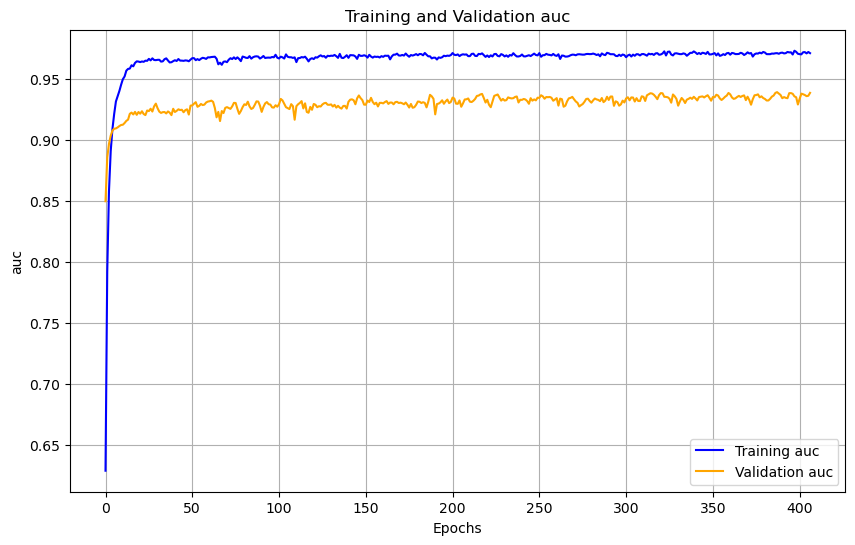

In [21]:
draw_metric(history, 'auc')

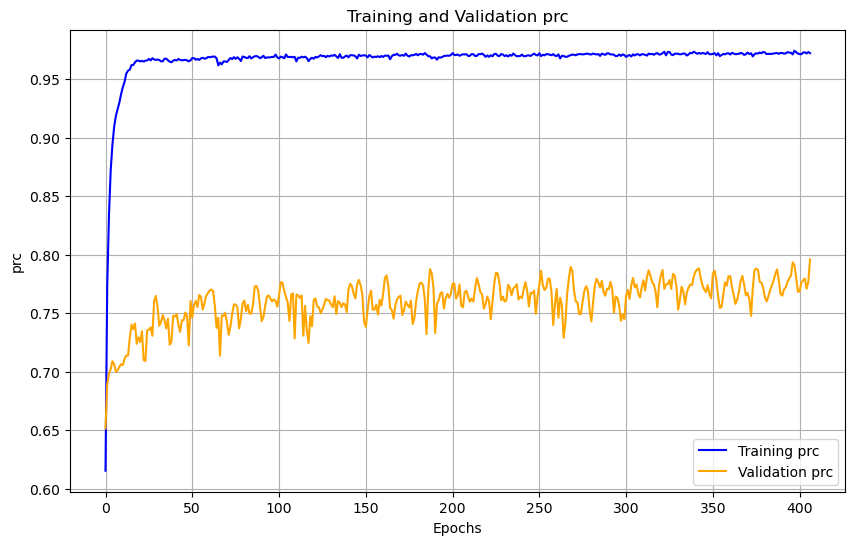

In [22]:
draw_metric(history, 'prc')

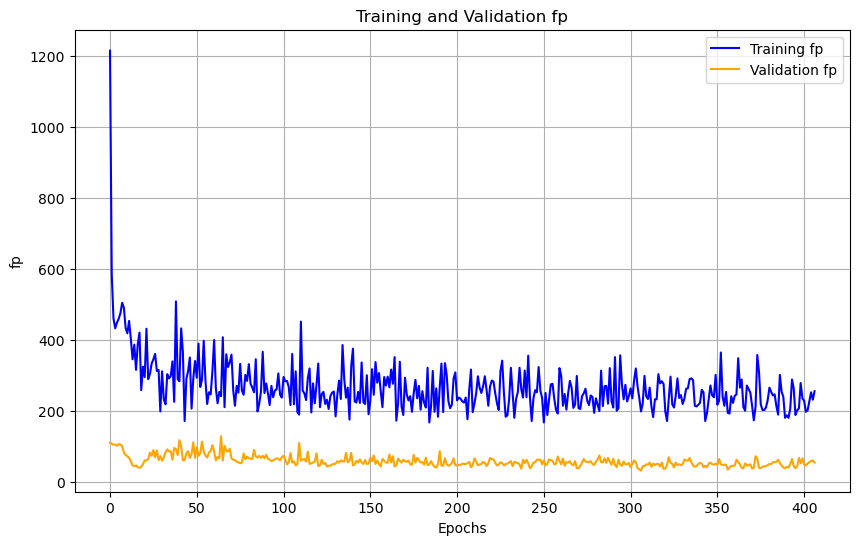

In [23]:
draw_metric(history, 'fp')

In [24]:
from sklearn.metrics import classification_report,  precision_score, recall_score, fbeta_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve

def get_classification_report(x, y_true, threshold=0.5):
 
    y_pred = model.predict(x, verbose=0)
    y_pred = ((y_pred >= threshold).astype(int).flatten())  # Convert probabilities to binary predictions

    return classification_report(y_true, y_pred)

def get_f2_score(x, y_true, beta = 2, threshold=0.5):
    y_pred = model.predict(x, verbose=0)
    y_pred = ((y_pred >= threshold).astype(int).flatten())  # Convert probabilities to binary predictions

    return fbeta_score(y_true, y_pred, beta=beta)

def get_precision(x, y_true, threshold=0.5):
    y_pred = model.predict(x, verbose=0)
    y_pred = ((y_pred >= threshold).astype(int).flatten())  # Convert probabilities to binary predictions

    return precision_score(y_true, y_pred)

def get_recall(x, y_true, threshold=0.5):
    y_pred = model.predict(x, verbose=0)
    y_pred = ((y_pred >= threshold).astype(int).flatten())  # Convert probabilities to binary predictions

    return recall_score(y_true, y_pred)

def get_auc(x, y_true):
    y_pred = model.predict(x, verbose=0)
    return roc_auc_score(y_true, y_pred)

def get_confusion_matrix(x, y_true, threshold=0.5):
    y_pred = model.predict(x, verbose=0)
    y_pred = ((y_pred >= threshold).astype(int).flatten())  
    cm = confusion_matrix(y_pred, y_true)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

def get_precision_recall_curve(x, y_true):
    y_pred = model.predict(x, verbose=0)
    # y_pred = ((y_pred >= threshold).astype(int).flatten())  
    ticks = np.linspace(0, 1, 10)
    plt.xticks(ticks)
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    plt.plot(thresholds, precision[:-1], label="Precision",)
    plt.plot(thresholds, recall[:-1], label="Recall")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend()
    plt.title("Precision-Recall vs. Threshold")
    plt.show()



<Figure size 1200x600 with 0 Axes>

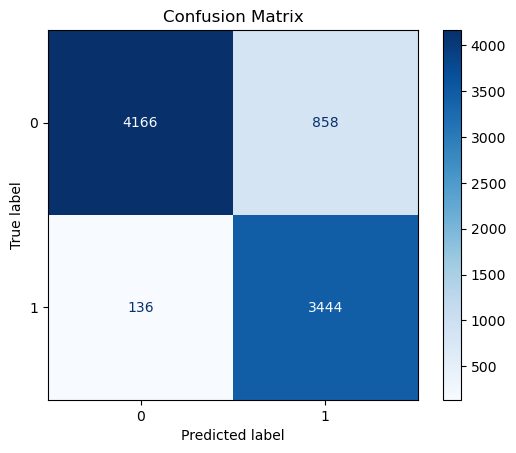

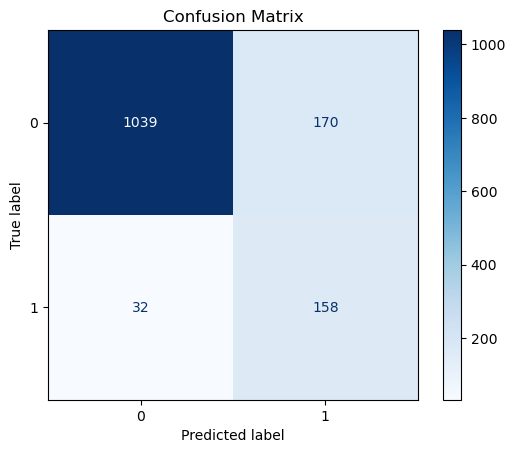

In [25]:

plt.figure(figsize=(12, 6))
x = x_train.astype(np.float32)
y = y_train.astype(np.float32)
get_confusion_matrix(x, y, THRESHOLD)

x = x_val.astype(np.float32)
y = y_val.astype(np.float32)
get_confusion_matrix(x, y, THRESHOLD)

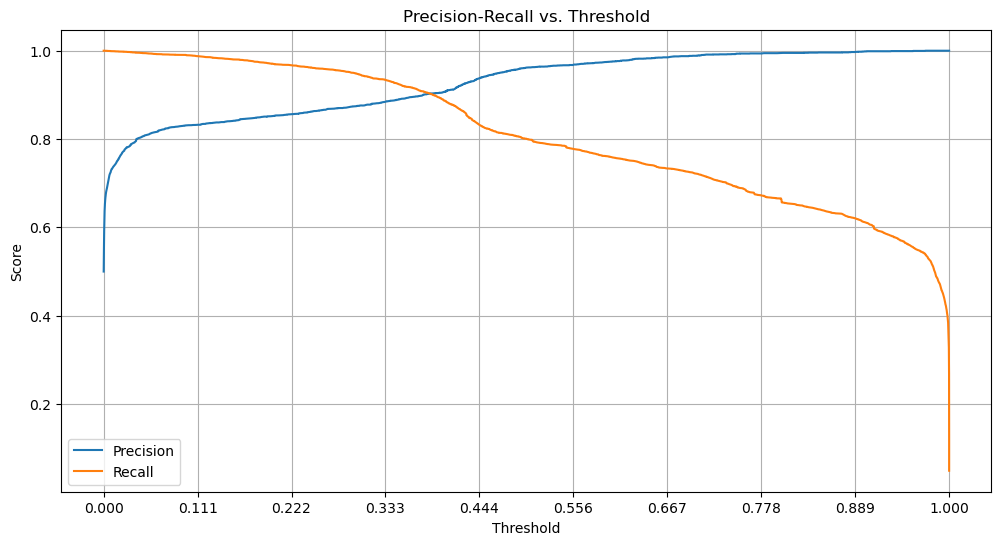

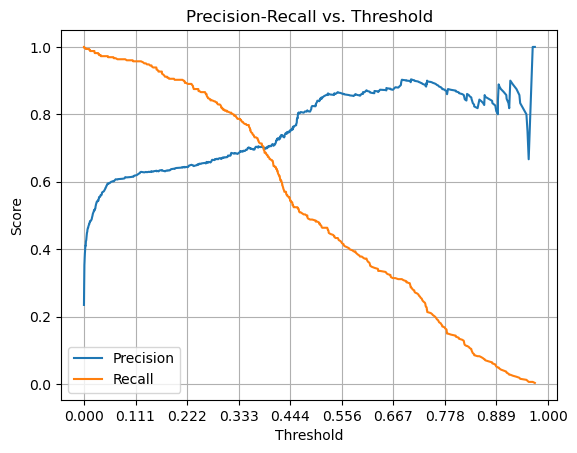

In [26]:

plt.figure(figsize=(12, 6))
plt.grid(True)
x = x_train.astype(np.float32)
y = y_train.astype(np.float32)
get_precision_recall_curve(x, y)
x = x_val.astype(np.float32)
y = y_val.astype(np.float32)
plt.grid(True)
get_precision_recall_curve(x, y)


In [27]:
# THRESHOLD = 0.575

In [28]:


x = x_train.astype(np.float32)
y = y_train.astype(np.float32)
fb = get_f2_score(x, y, beta=2, threshold = THRESHOLD, )
pr = get_precision(x, y, THRESHOLD)
re = get_recall(x, y, THRESHOLD)
auc = get_auc(x, y)
print("Training")
print("F2 Score: ", fb)
print("Precision: ", pr)
print("Recall: ", re)
print("AUC: ", auc)
print(get_classification_report(x, y, THRESHOLD))

print("*" * 100)

x = x_val.astype(np.float32)
y = y_val.astype(np.float32)
fb = get_f2_score(x, y, beta=2, threshold = THRESHOLD, )
pr = get_precision(x, y, THRESHOLD)
re = get_recall(x, y, THRESHOLD)
auc = get_auc(x, y)
print("Validation")
print("F2 Score: ", fb)
print("Precision: ", pr)
print("Recall: ", re)
print("AUC: ", auc)
print(get_classification_report(x, y, THRESHOLD))


Training
F2 Score:  0.8283625168366365
Precision:  0.9620111731843576
Recall:  0.800557880055788
AUC:  0.9763116297848123
              precision    recall  f1-score   support

         0.0       0.83      0.97      0.89      4302
         1.0       0.96      0.80      0.87      4302

    accuracy                           0.88      8604
   macro avg       0.90      0.88      0.88      8604
weighted avg       0.90      0.88      0.88      8604

****************************************************************************************************
Validation
F2 Score:  0.525965379494008
Precision:  0.8315789473684211
Recall:  0.4817073170731707
AUC:  0.9352127029673658
              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91      1071
         1.0       0.83      0.48      0.61       328

    accuracy                           0.86      1399
   macro avg       0.85      0.73      0.76      1399
weighted avg       0.85      0.86      0.84      1399


In [29]:
# import shap
# # Create an explainer (for tree-based models)

# # Randomly select 100 indices from x_train
# indices = np.random.choice(x_train.shape[0], size=100, replace=False)

# # Use these indices to select rows from x_train
# background = x_train[indices]

# explainer = shap.DeepExplainer(model, background)

# # Calculate SHAP values for the train set
# shap_values = explainer.shap_values(x_train)

In [30]:
# shap.summary_plot(shap_values.squeeze(axis=-1), features=Features, plot_type='bar', max_display=60)